Playgroud to test the model :) <br>
1. Change the number_of_results to get reults back <br>
2. batch size == number of cores , if you have gpu as much you would like. <br>
3. ./databse is the databse of images from which we lookup <br>
4. query.jpg is query picture

In [1]:
#from keras.applications.resnet50 import ResNet50
#d_model = ResNet50(include_top=False,weights="imagenet",pooling = "avg")
#d_model.save("./resnet50.h5")

In [2]:
from tqdm import tqdm
from pathlib import Path
import os
os.chdir("./..")

In [3]:
Path_of_database = Path("./database")
Path_of_query = str(Path("./") / "query.jpg")
features_of_database = "./model_files/feature_embeddings.h5"
filenames_of_database = "./model_files/dataset_names.csv"
number_of_results =8
batch_size = 5
threads=batch_size

In [4]:
import keras
model=keras.models.load_model("./model_files/resnet50.h5")

Using TensorFlow backend.
C:\Users\bazif\anaconda3\envs\tf\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
model.Trainable=False

In [6]:
list_of_files = os.listdir(Path_of_database)
list_of_files = [ i for i in list_of_files if ".jpg" in i]
n_files=len(list_of_files)
#print(list_of_files)

In [7]:
import h5py
file = h5py.File(features_of_database, "w")    
feature_emb = file.create_dataset("features", (len(list_of_files)+batch_size,2048), h5py.h5t.IEEE_F32LE,compression="lzf")

In [8]:
import cv2
def pre_proc(img):
    return cv2.resize(img,(256,256),interpolation = cv2.INTER_AREA)
   

In [9]:
batch_matr = [x for x in range(0,n_files)]
def batch_preprocess(i):
    matrix = cv2.imread(str(Path_of_database / list_of_files[i]))
    matrix = pre_proc(matrix)
    #print("that",matrix)
    global batch_matr
    batch_matr[i]=matrix

In [10]:
from concurrent.futures import ThreadPoolExecutor
import numpy as np
def parallel_read(begin,end):
    with ThreadPoolExecutor(max_workers=batch_size) as executor:
        for i in range(begin,end+1):
            executor.submit(batch_preprocess,(i))
    return np.array(batch_matr[begin:end+1],dtype='f')

In [11]:
def read_data(beg,end):
    if end>=n_files:
        end=n_files-1
    if beg>=n_files:
        return np.zeros(shape=(batch_size, 256, 256, 3),)
    batch_value=parallel_read(beg,end)
    return batch_value

In [12]:
#file.close()


In [13]:
for index_i in tqdm(range(0,(n_files+batch_size//batch_size),batch_size)):
    batch=read_data(index_i,index_i+batch_size-1)
    res=model.predict(batch)
    for i,each in enumerate(res):
        feature_emb[index_i+i,...]=each
        #print(each.shape,index_i+i,batch.shape)
file.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.82it/s]


In [14]:
def store_filename(l_o_f):
    with open(filenames_of_database,"w+") as f:
        for i,each in enumerate(l_o_f):
            f.write(str(each)+","+str(i)+"\n")

In [ ]:
load = h5py.File(features_of_database,"r")
arr = np.array(load["features"])
from sklearn.preprocessing import StandardScaler
sl = StandardScaler()
arr = sl.fit_transform(arr)
from sklearn.decomposition import PCA
pc = PCA(n_components=256)
arr=pc.fit_transform(arr)
load.close()
h5py.File(features_of_database,"w")

In [15]:
store_filename(list_of_files)

In [16]:
import pandas as pd
dataset_filenames = pd.read_csv(filenames_of_database,header=None)
#print(dataset_filenames)

In [17]:
def query_pic(path):
    img = cv2.imread(path)
    img = pre_proc(img)
    return (model.predict(img[None,...]))

In [18]:
from scipy.spatial import distance
def calculate_distances(n):
    vector=query_pic(Path_of_query)
    ld = h5py.File(features_of_database,"r")
    values = []
    for each in ld["features"]:
        if(np.sum(each))<0.5:
            values.append(-999)
            break
        values.append((1-distance.cosine(each,vector)))
    #print(len(values))
    from operator import itemgetter
    from heapq import nlargest
    return nlargest(n, enumerate(values), itemgetter(1))

<Figure size 432x288 with 0 Axes>

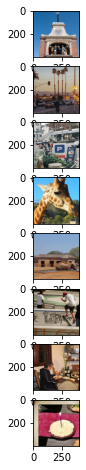

In [19]:
results=calculate_distances(number_of_results)
import matplotlib.pyplot as plt

plt.figure()
fig=plt.figure(figsize=(8, 8))
columns = 1
rows = number_of_results

for i in range(1, columns*rows +1):
    img=plt.imread(str(Path_of_database / dataset_filenames.loc[results[i-1][0]][0]))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()